In [1]:
import pandas as pd
import seaborn as sns
import igraph
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Load data

In [2]:

g = igraph.load('../data/florida_coa_graph',format='pickle')

#Here is how to map for to get authors / papers
method = 'florida'
a_2_node = np.load('%s/data/%s_a_2_node.npy'%('..',method),allow_pickle='TRUE').item()
a_2_paper = np.load('%s/data/%s_a_2_paper.npy'%('..',method),allow_pickle='TRUE').item()
node_2_a = np.load('%s/data/%s_node_2_a.npy'%('..',method),allow_pickle='TRUE').item()

In [3]:
g.summary()

'IGRAPH UN-- 151936 1492921 -- \n+ attr: name (v), year (e)'

In [ ]:
visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (600,300)
visual_style["margin"] = 17

# Set vertex colours
visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 5

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = True

# Set the layout
my_layout = g.layout_fruchterman_reingold()
visual_style["layout"] = my_layout

# Plot the graph
igraph.plot(g, **visual_style)

In [13]:
print("Number of vertices:", g.vcount())
print("Number of edges:", g.ecount())
print("Density of the graph:", 2*g.ecount()/(g.vcount()*(g.vcount()-1)))

Number of vertices: 151936
Number of edges: 1492921
Density of the graph: 0.00012934460053903355


In [10]:
degrees = []
total = 0

for n in range(g.vcount()):
    neighbours = g.neighbors(n, mode='ALL')
    total += len(neighbours)
    degrees.append(len(neighbours))
    
print("Average degree:", total/g.vcount())
print("Maximum degree:", max(degrees))
print("Author with the maximum degree:", node_2_a[degrees.index(max(degrees))])

Average degree: 19.651971882898064
Maximum degree: 1072
Author with the maximum degree: Geschwind, Daniel H.


Degree having the maximum number of vertices: 6
Number of vertices having the most abundant degree: 10551


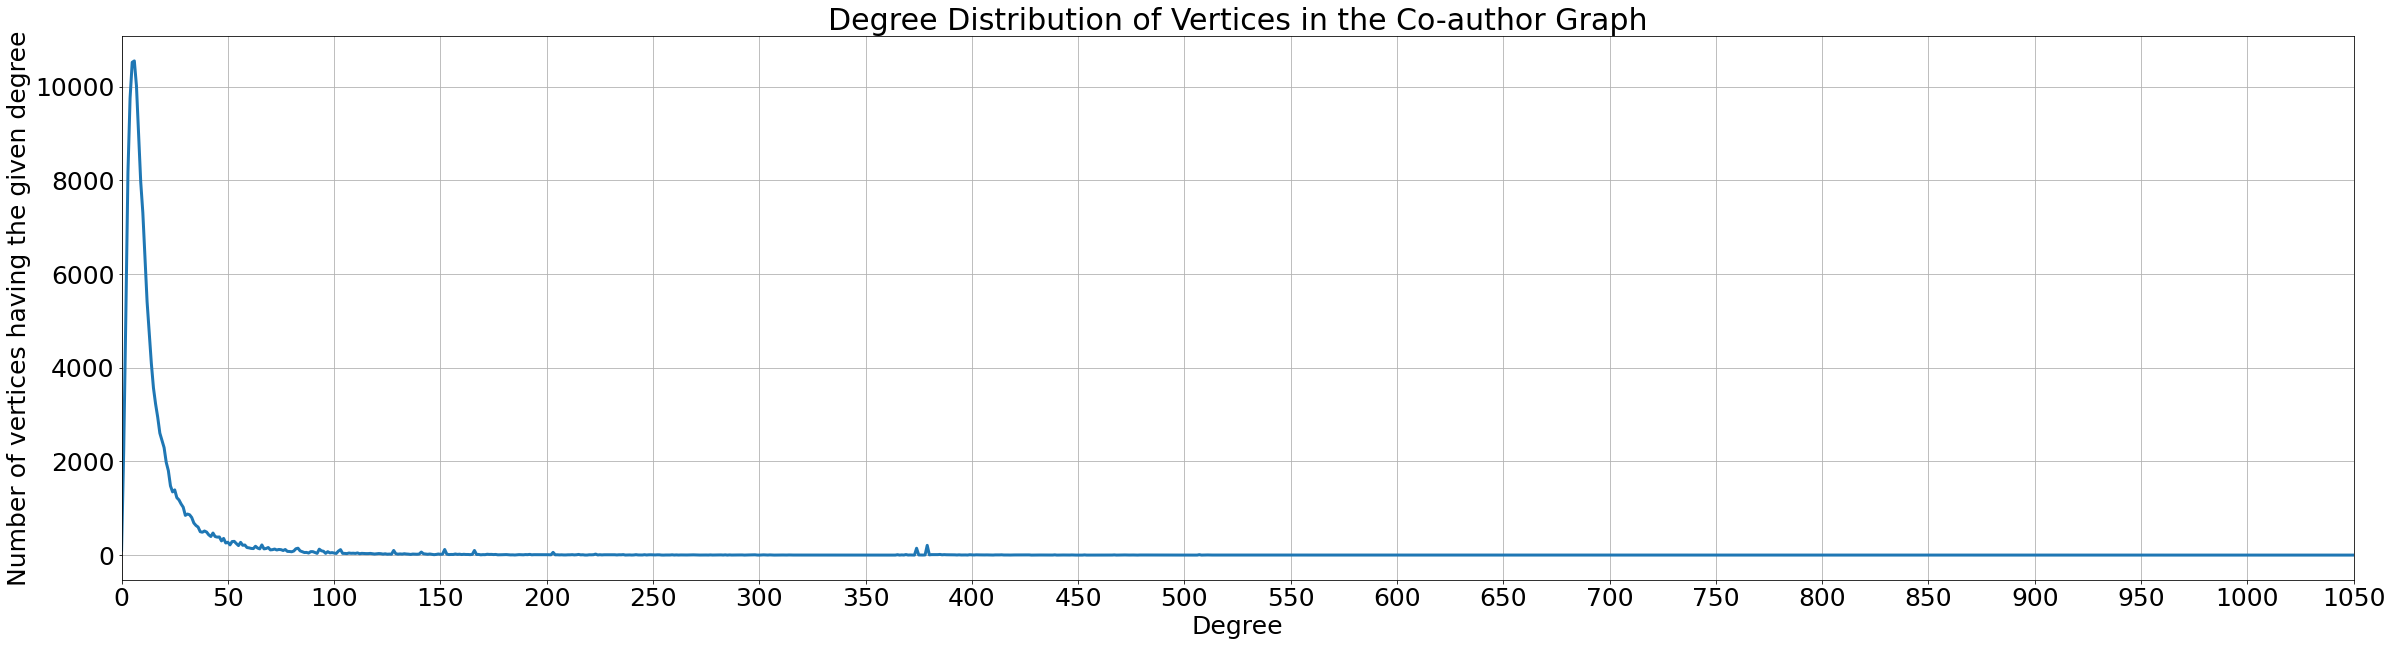

<Figure size 432x288 with 0 Axes>

In [30]:
plt.rcParams.update({'font.size': 25})

x = [x for x in range(max(degrees)+1)]
degree_counts = [0 for x in range(1073)]

for i in degrees:
    degree_counts[i] += 1

print("Degree having the maximum number of vertices:", degree_counts.index(max(degree_counts)))
print("Number of vertices having the most abundant degree:", max(degree_counts))

plt.figure(figsize=(40,10))
plt.plot(x, degree_counts, linewidth=3.0)
plt.ylabel('Number of vertices having the given degree')
plt.xlabel('Degree')
plt.title('Degree Distribution of Vertices in the Co-author Graph')

plt.xlim(0,100)
plt.xticks(np.arange(min(x), max(x)+1, 50.0))
plt.grid(True)
plt.show()
plt.draw()

## Get gender of names

'Iannetti, Gian Domenico'